In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Dataset Chest X-rays Images"

In [ ]:
path

'/content/drive/MyDrive/Dataset Chest X-rays Images'

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from scipy.ndimage import gaussian_laplace
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# --- 1. KONFIGURASI ---
base_dataset_dir = '/content/drive/MyDrive/Dataset Chest X-rays Images'
categories = ['Normal', 'TBC']
IMG_SIZE = 256

# --- 2. FUNGSI UTILS (ROI & PIPELINE) ---
def extract_roi(image, mask):
    coords = cv2.findNonZero(mask)
    if coords is None: return image
    x, y, w, h = cv2.boundingRect(coords)
    roi_crop = image[y:y+h, x:x+w]
    return cv2.resize(roi_crop, (IMG_SIZE, IMG_SIZE))

def process_image_auto(img_path):
    img = cv2.imread(img_path, 0)
    if img is None: return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Preprocessing & Otsu
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)
    blur = cv2.GaussianBlur(img_clahe, (5,5), 0)
    _, mask_pred = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if mask_pred[0, 0] > 127: mask_pred = cv2.bitwise_not(mask_pred)

    # Morphology
    kernel = np.ones((5,5), np.uint8)
    mask_pred = cv2.morphologyEx(mask_pred, cv2.MORPH_OPEN, kernel)
    mask_pred = cv2.morphologyEx(mask_pred, cv2.MORPH_CLOSE, kernel)

    # Crop
    segmented_img = cv2.bitwise_and(img_clahe, img_clahe, mask=mask_pred)
    final_roi = extract_roi(segmented_img, mask_pred)
    return final_roi

# --- 3. FUNGSI AUGMENTASI (Hanya Putar & Flip) ---
def augment_roi(image):
    augmented = []
    # 1. Flip
    augmented.append(cv2.flip(image, 1))
    # 2. Rotasi Kecil
    rows, cols = image.shape
    for angle in [5, -5]:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        augmented.append(cv2.warpAffine(image, M, (cols, rows)))
    return augmented

# --- 4. EKSTRAKSI FITUR ---
def extract_features(image):
    features = []
    # Stats Pixel (Mean/Std/Skew) -> Kadang ini bikin bias kalau alat rontgen beda
    # Kita kurangi ketergantungan pada pixel raw
    pixels = image.ravel()
    features.extend([np.mean(pixels), np.std(pixels), skew(pixels)])

    # GLCM
    try:
        glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        for p in ['contrast', 'energy', 'correlation', 'ASM']: # Ambil yg penting aja
            features.append(graycoprops(glcm, p).mean())
    except: features.extend([0]*4)

    # HOG (Fitur Utama)
    try:
        fd = hog(image, orientations=8, pixels_per_cell=(32, 32),
                 cells_per_block=(1, 1), visualize=False)
        features.extend(fd)
    except: features.extend([0]*100)

    return np.array(features)

# ==========================================
# 5. SPLIT DULU, BARU PROSES (ANTI-LEAKAGE)
# ==========================================
print("🚀 Tahap 1: Mengumpulkan Daftar File...")

# Kita simpan Path-nya dulu, jangan gambarnya
file_paths = []
labels = []

for category in categories:
    folder_path = os.path.join(base_dataset_dir, category)
    class_label = categories.index(category)
    if os.path.exists(folder_path):
        fnames = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for f in fnames:
            file_paths.append(f)
            labels.append(class_label)

# Convert ke array
file_paths = np.array(file_paths)
labels = np.array(labels)

# SPLIT DISINI! (Sebelum gambar dibaca/diaugmentasi)
print("✂️ Tahap 2: Membagi Data Train/Test (Split 80:20)...")
X_train_files, X_test_files, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Jumlah Data Train Awal: {len(X_train_files)}")
print(f"Jumlah Data Test (Murni): {len(X_test_files)}")


# ==========================================
# 6. PROSES DATA TRAIN (DENGAN AUGMENTASI)
# ==========================================
print("\n💪 Tahap 3: Memproses Data TRAINING (Normal diperbanyak)...")

X_train_feats = []
y_train_final = []

for i, path in enumerate(tqdm(X_train_files)):
    label = y_train[i]
    category = categories[label]

    # Proses gambar
    roi = process_image_auto(path)
    if roi is not None:
        # Masukkan data asli
        feats = extract_features(roi)
        X_train_feats.append(feats)
        y_train_final.append(label)

        # JIKA NORMAL -> Lakukan Augmentasi (HANYA DI DATA TRAIN!)
        if category == 'Normal':
            aug_imgs = augment_roi(roi)
            for aug in aug_imgs:
                feats_aug = extract_features(aug)
                X_train_feats.append(feats_aug)
                y_train_final.append(label)

# ==========================================
# 7. PROSES DATA TEST (TANPA AUGMENTASI)
# ==========================================
print("\n🧐 Tahap 4: Memproses Data TESTING (Tanpa sentuhan)...")

X_test_feats = []
y_test_final = [] # Harusnya sama dengan y_test, tapi jaga2 kalau ada gambar error

for i, path in enumerate(tqdm(X_test_files)):
    roi = process_image_auto(path)
    if roi is not None:
        feats = extract_features(roi)
        X_test_feats.append(feats)
        y_test_final.append(y_test[i])

# ==========================================
# 8. TRAINING & EVALUASI JUJUR
# ==========================================
X_train_final = np.array(X_train_feats)
y_train_final = np.array(y_train_final)
X_test_final = np.array(X_test_feats)
y_test_final = np.array(y_test_final)

# Bersihkan NaN
X_train_final = np.nan_to_num(X_train_final)
X_test_final = np.nan_to_num(X_test_final)

print(f"\n📊 Statistik Akhir:")
print(f"Data Train (Setelah Augmentasi): {len(X_train_final)} (Lihat, Normal jadi banyak!)")
print(f"Data Test (Asli): {len(X_test_final)}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# Seleksi Fitur
print("🔍 Seleksi Fitur...")
rf_sel = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_sel.fit(X_train_scaled, y_train_final)
fs = SelectFromModel(rf_sel, threshold='median')
X_train_fs = fs.fit_transform(X_train_scaled, y_train_final)
X_test_fs = fs.transform(X_test_scaled)

# Training Random Forest
print("🔥 Training Random Forest...")
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_fs, y_train_final)

# Prediksi
y_pred = rf.predict(X_test_fs)

print("\n=== HASIL EVALUASI (ANTI-OVERFITTING) ===")
print(classification_report(y_test_final, y_pred, target_names=categories))
print(f"Akurasi: {accuracy_score(y_test_final, y_pred)*100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test_final, y_pred))

🚀 Tahap 1: Mengumpulkan Daftar File...
✂️ Tahap 2: Membagi Data Train/Test (Split 80:20)...
Jumlah Data Train Awal: 2406
Jumlah Data Test (Murni): 602

💪 Tahap 3: Memproses Data TRAINING (Normal diperbanyak)...


100%|██████████| 2406/2406 [01:16<00:00, 31.58it/s]



🧐 Tahap 4: Memproses Data TESTING (Tanpa sentuhan)...


100%|██████████| 602/602 [00:10<00:00, 58.61it/s]



📊 Statistik Akhir:
Data Train (Setelah Augmentasi): 3639 (Lihat, Normal jadi banyak!)
Data Test (Asli): 602
🔍 Seleksi Fitur...
🔥 Training Random Forest...

=== HASIL EVALUASI (ANTI-OVERFITTING) ===
              precision    recall  f1-score   support

      Normal       0.93      0.98      0.95       103
         TBC       1.00      0.98      0.99       499

    accuracy                           0.98       602
   macro avg       0.96      0.98      0.97       602
weighted avg       0.98      0.98      0.98       602

Akurasi: 98.34%
Confusion Matrix:
[[101   2]
 [  8 491]]


Silakan Upload Gambar X-Ray Baru untuk Ditest:


Saving others (457).jpg to others (457).jpg


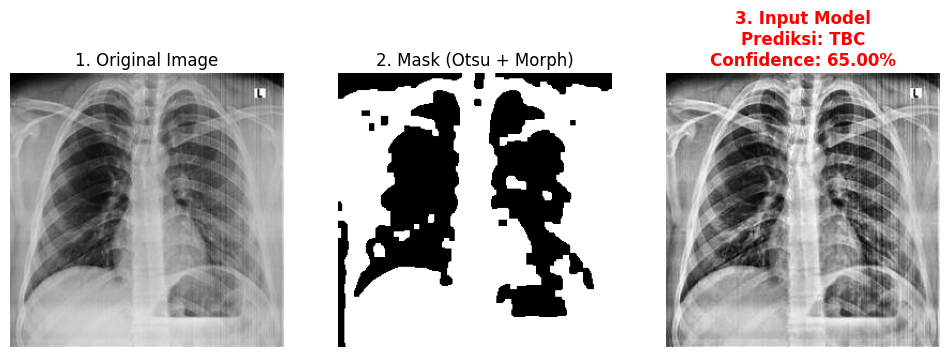

------------------------------
🩺 HASIL DIAGNOSA
------------------------------
Status     : TBC
Probabilitas: Normal=35.0%, TBC=65.0%
------------------------------


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# --- FUNGSI TESTING KHUSUS (Visualisasi Step-by-Step) ---
def test_single_image_safe(path_img):
    # 1. BACA GAMBAR
    img = cv2.imread(path_img, 0)
    if img is None:
        print("Error: Gambar tidak terbaca/corrupt.")
        return

    # 2. REPLIKASI PREPROCESSING (Sama persis dengan process_image_auto)
    # Resize
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Preprocessing
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_resized)

    # Otsu & Masking
    blur = cv2.GaussianBlur(img_clahe, (5,5), 0)
    _, mask_pred = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Inversi jika background putih
    if mask_pred[0, 0] > 127:
        mask_pred = cv2.bitwise_not(mask_pred)

    # Morphology
    kernel = np.ones((5,5), np.uint8)
    mask_pred = cv2.morphologyEx(mask_pred, cv2.MORPH_OPEN, kernel)
    mask_pred = cv2.morphologyEx(mask_pred, cv2.MORPH_CLOSE, kernel)

    # ROI Crop
    coords = cv2.findNonZero(mask_pred)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        roi_crop = img_clahe[y:y+h, x:x+w]
        final_roi = cv2.resize(roi_crop, (IMG_SIZE, IMG_SIZE))
    else:
        final_roi = img_clahe
        print("⚠️ Warning: Otsu gagal (Blank Mask). Menggunakan gambar full.")

    # 3. EKSTRAKSI FITUR
    # Panggil fungsi extract_features yang sudah ada di memori training
    features = extract_features(final_roi)

    # 4. PERSIAPAN DATA (PENTING: Jangan di-fit ulang!)
    features = features.reshape(1, -1)     # Ubah jadi baris (1, n_features)
    features = np.nan_to_num(features)     # Jaga-jaga ada NaN

    # A. Scaling (Pakai scaler dari training)
    # Gunakan .transform(), BUKAN .fit_transform()
    features_scaled = scaler.transform(features)

    # B. Seleksi Fitur (Pakai fs dari training)
    features_final = fs.transform(features_scaled)

    # 5. PREDIKSI
    prediction = rf.predict(features_final)[0]
    probabilities = rf.predict_proba(features_final)[0]

    label_pred = categories[prediction]
    conf_score = np.max(probabilities) * 100

    # --- VISUALISASI ---
    plt.figure(figsize=(12, 5))

    # Gambar Asli
    plt.subplot(1, 3, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("1. Original Image")
    plt.axis('off')

    # Masker Otsu
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred, cmap='gray')
    plt.title("2. Mask (Otsu + Morph)")
    plt.axis('off')

    # ROI Final
    plt.subplot(1, 3, 3)
    plt.imshow(final_roi, cmap='gray')

    # Judul Hasil
    if label_pred == "Normal":
        color_res = 'green'
    else:
        color_res = 'red'

    plt.title(f"3. Input Model\nPrediksi: {label_pred}\nConfidence: {conf_score:.2f}%",
              color=color_res, fontweight='bold')
    plt.axis('off')

    plt.show()

    print("-" * 30)
    print(f"🩺 HASIL DIAGNOSA")
    print("-" * 30)
    print(f"Status     : {label_pred}")
    print(f"Probabilitas: Normal={probabilities[0]*100:.1f}%, TBC={probabilities[1]*100:.1f}%")
    print("-" * 30)

# --- UPLOAD FILE ---
print("Silakan Upload Gambar X-Ray Baru untuk Ditest:")
uploaded = files.upload()

for fn in uploaded.keys():
    test_single_image_safe(fn)

In [ ]:
import os
import cv2
import numpy as np
import random
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# --- 1. KONFIGURASI ---
base_dataset_dir = '/content/drive/MyDrive/PACD Data'
categories = ['Normal', 'TBC']
IMG_SIZE = 256
TARGET_COUNT = 500 # Kita batasi TBC cuma boleh masuk segini

# --- 2. FUNGSI UTILS (OTSU & FEATURE) ---
def extract_roi(image, mask):
    coords = cv2.findNonZero(mask)
    if coords is None: return image
    x, y, w, h = cv2.boundingRect(coords)
    roi_crop = image[y:y+h, x:x+w]
    return cv2.resize(roi_crop, (IMG_SIZE, IMG_SIZE))

def process_image_auto(img_path):
    img = cv2.imread(img_path, 0)
    if img is None: return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)
    blur = cv2.GaussianBlur(img_clahe, (5,5), 0)
    _, mask_pred = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if mask_pred[0, 0] > 127: mask_pred = cv2.bitwise_not(mask_pred)
    kernel = np.ones((5,5), np.uint8)
    mask_pred = cv2.morphologyEx(mask_pred, cv2.MORPH_OPEN, kernel)
    mask_pred = cv2.morphologyEx(mask_pred, cv2.MORPH_CLOSE, kernel)
    segmented_img = cv2.bitwise_and(img_clahe, img_clahe, mask=mask_pred)
    final_roi = extract_roi(segmented_img, mask_pred)
    return final_roi

def extract_features(image):
    features = []
    # Stats
    pixels = image.ravel()
    features.extend([np.mean(pixels), np.std(pixels), skew(pixels)])
    # GLCM
    try:
        glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        for p in ['contrast', 'energy', 'correlation', 'ASM']:
            features.append(graycoprops(glcm, p).mean())
    except: features.extend([0]*4)
    # HOG
    try:
        fd = hog(image, orientations=8, pixels_per_cell=(32, 32),
                 cells_per_block=(1, 1), visualize=False)
        features.extend(fd)
    except: features.extend([0]*100)
    return np.array(features)

# ==========================================
# 3. PENGAMBILAN DATA (UNDERSAMPLING TBC)
# ==========================================
print("🚀 Tahap 1: Mengambil Data (TBC DIPOTONG BIAR ADIL)...")

file_paths = []
labels = []

for category in categories:
    folder_path = os.path.join(base_dataset_dir, category)
    class_label = categories.index(category)

    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # --- LOGIKA POTONG DATA ---
        if category == 'TBC':
            # Acak dulu biar gak ngambil yang urut
            random.shuffle(all_files)
            # Cuma ambil 500-an (sesuai jumlah normal)
            selected_files = all_files[:TARGET_COUNT]
            print(f"  -> TBC dipotong dari {len(all_files)} menjadi {len(selected_files)}")
        else:
            # Normal ambil semua
            selected_files = all_files
            print(f"  -> Normal diambil semua: {len(selected_files)}")

        for f in selected_files:
            file_paths.append(f)
            labels.append(class_label)

# Convert
file_paths = np.array(file_paths)
labels = np.array(labels)

# ==========================================
# 4. SPLIT & PROCESS
# ==========================================
print("\n✂️ Tahap 2: Split Train/Test...")
X_train_files, X_test_files, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print("\n💪 Tahap 3: Ekstraksi Fitur (Sabar ya)...")
def get_data(files, y_labels):
    X_data = []
    y_data = []
    for i, path in enumerate(tqdm(files)):
        roi = process_image_auto(path)
        if roi is not None:
            feats = extract_features(roi)
            X_data.append(feats)
            y_data.append(y_labels[i])
    return np.array(X_data), np.array(y_data)

X_train, y_train = get_data(X_train_files, y_train)
X_test, y_test = get_data(X_test_files, y_test)

# Bersihkan NaN
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# ==========================================
# 5. TRAINING JURUS ANTI-BIAS
# ==========================================
print(f"\n📊 Data Final: Train={len(X_train)}, Test={len(X_test)}")
print("Harusnya jumlah Normal dan TBC sekarang mirip banget.")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Seleksi Fitur
print("🔍 Seleksi Fitur...")
rf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sel.fit(X_train_scaled, y_train)
fs = SelectFromModel(rf_sel, threshold='median')
X_train_fs = fs.fit_transform(X_train_scaled, y_train)
X_test_fs = fs.transform(X_test_scaled)

# Training (Gak perlu class_weight='balanced' lagi karena data udah imbang)
print("🔥 Training Random Forest...")
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train_fs, y_train)

# Prediksi
y_pred = rf.predict(X_test_fs)

print("\n=== HASIL AKHIR (UNDERSAMPLING) ===")
print(classification_report(y_test, y_pred, target_names=categories))
print(f"Akurasi: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

🚀 Tahap 1: Mengambil Data (TBC DIPOTONG BIAR ADIL)...
  -> Normal diambil semua: 514
  -> TBC dipotong dari 2494 menjadi 500

✂️ Tahap 2: Split Train/Test...

💪 Tahap 3: Ekstraksi Fitur (Sabar ya)...


100%|██████████| 203/203 [00:03<00:00, 66.63it/s]



📊 Data Final: Train=811, Test=203
Harusnya jumlah Normal dan TBC sekarang mirip banget.
🔍 Seleksi Fitur...
🔥 Training Random Forest...

=== HASIL AKHIR (UNDERSAMPLING) ===
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       103
         TBC       0.98      0.98      0.98       100

    accuracy                           0.98       203
   macro avg       0.98      0.98      0.98       203
weighted avg       0.98      0.98      0.98       203

Akurasi: 98.03%
Confusion Matrix:
[[101   2]
 [  2  98]]


Silakan Upload Gambar X-Ray Baru:


Saving Normal-98.png to Normal-98.png


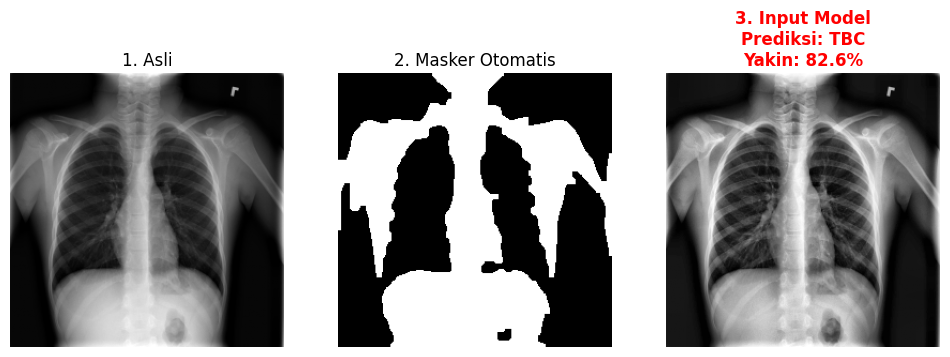

------------------------------
🩺 HASIL DIAGNOSA (Model Undersampling)
------------------------------
Status     : TBC
Probabilitas: Normal=17.4%, TBC=82.6%
------------------------------


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# --- FUNGSI TESTING SINGLE IMAGE (KHUSUS UNDERSAMPLING MODEL) ---
def test_single_image_undersampled(path_img):
    # 1. BACA GAMBAR
    img = cv2.imread(path_img, 0)
    if img is None:
        print("Error: Gambar tidak terbaca.")
        return

    # 2. PREPROCESSING (REPLIKASI LOGIKA TRAINING)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_resized)

    # 3. PREDICT MASK (Otsu)
    blur = cv2.GaussianBlur(img_clahe, (5,5), 0)
    _, mask_pred = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Inversi jika background putih
    if mask_pred[0, 0] > 127:
        mask_pred = cv2.bitwise_not(mask_pred)

    # 4. MORPHOLOGY
    kernel = np.ones((5,5), np.uint8)
    mask_pred = cv2.morphologyEx(mask_pred, cv2.MORPH_OPEN, kernel)
    mask_pred = cv2.morphologyEx(mask_pred, cv2.MORPH_CLOSE, kernel)

    # 5. ROI CROP
    coords = cv2.findNonZero(mask_pred)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        roi_crop = img_clahe[y:y+h, x:x+w]
        final_roi = cv2.resize(roi_crop, (IMG_SIZE, IMG_SIZE))
    else:
        final_roi = img_clahe
        print("⚠️ Warning: Otsu gagal (Blank Mask). Menggunakan gambar full.")

    # 6. EKSTRAKSI FITUR
    # Panggil fungsi extract_features yang sudah ada di memori
    features = extract_features(final_roi)

    # 7. PERSIAPAN DATA (Transform Only)
    features = features.reshape(1, -1)     # Ubah jadi baris
    features = np.nan_to_num(features)     # Bersihin NaN

    # A. Scaling (Pakai scaler training)
    features_scaled = scaler.transform(features)

    # B. Seleksi Fitur (Pakai fs training)
    features_final = fs.transform(features_scaled)

    # 8. PREDIKSI (Pakai rf training)
    prediction = rf.predict(features_final)[0]
    probabilities = rf.predict_proba(features_final)[0]

    label_pred = categories[prediction]
    conf_score = np.max(probabilities) * 100

    # --- VISUALISASI ---
    plt.figure(figsize=(12, 5))

    # Gambar Asli
    plt.subplot(1, 3, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("1. Asli")
    plt.axis('off')

    # Masker Otsu
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred, cmap='gray')
    plt.title("2. Masker Otomatis")
    plt.axis('off')

    # ROI & Hasil
    plt.subplot(1, 3, 3)
    plt.imshow(final_roi, cmap='gray')

    # Judul Hasil dengan Warna
    color_res = 'green' if label_pred == "Normal" else 'red'

    plt.title(f"3. Input Model\nPrediksi: {label_pred}\nYakin: {conf_score:.1f}%",
              color=color_res, fontweight='bold')
    plt.axis('off')

    plt.show()

    print("-" * 30)
    print(f"🩺 HASIL DIAGNOSA (Model Undersampling)")
    print("-" * 30)
    print(f"Status     : {label_pred}")
    print(f"Probabilitas: Normal={probabilities[0]*100:.1f}%, TBC={probabilities[1]*100:.1f}%")
    print("-" * 30)

# --- UPLOAD FILE ---
print("Silakan Upload Gambar X-Ray Baru:")
uploaded = files.upload()

for fn in uploaded.keys():
    test_single_image_undersampled(fn)

Upload Gambar Normal yang salah ditebak jadi TBC:


Saving Normal-99.png to Normal-99.png


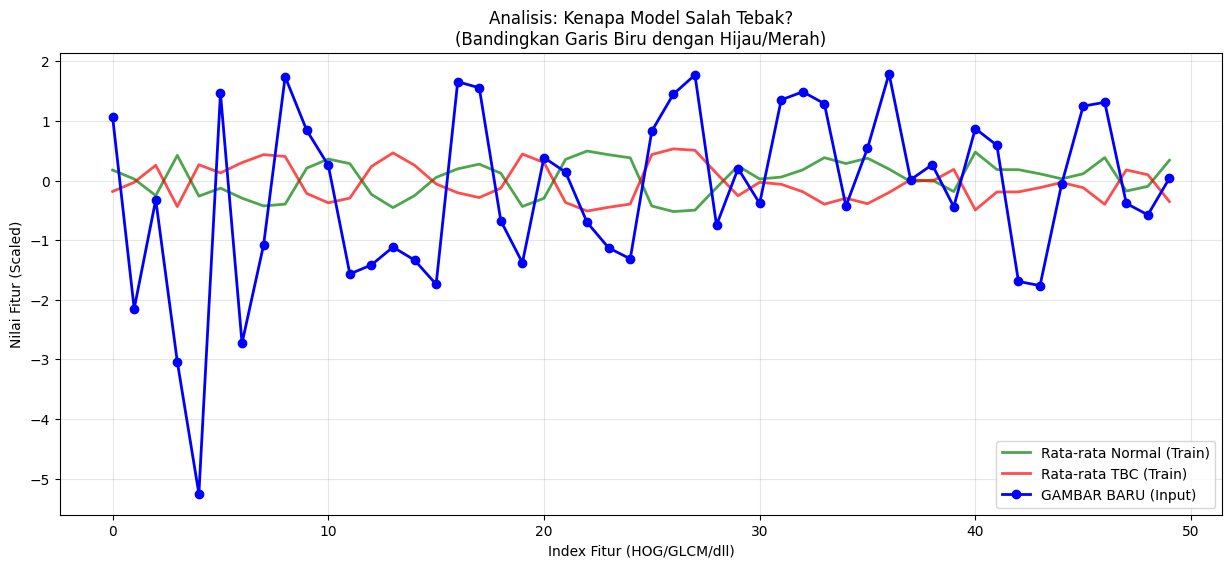

Jarak Fitur ke Rata-rata Normal: 19.01
Jarak Fitur ke Rata-rata TBC   : 18.79
>> Secara matematis, gambar ini memang lebih mirip profil TBC.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import cv2

# --- FUNGSI DEBUGGING FITUR ---
def debug_feature_distribution(path_new_img):
    # 1. Proses Gambar Baru
    img = cv2.imread(path_new_img, 0)
    if img is None: return

    # Preprocessing sama persis
    img_r = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_c = clahe.apply(img_r)
    blur = cv2.GaussianBlur(img_c, (5,5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if mask[0, 0] > 127: mask = cv2.bitwise_not(mask)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # ROI
    coords = cv2.findNonZero(mask)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        roi = img_c[y:y+h, x:x+w]
        roi = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
    else:
        roi = img_c

    # Ekstraksi Fitur Mentah
    new_feat = extract_features(roi)
    new_feat = new_feat.reshape(1, -1)
    new_feat = np.nan_to_num(new_feat)

    # Scale & Select (PENTING!)
    new_feat_scaled = scaler.transform(new_feat)
    new_feat_final = fs.transform(new_feat_scaled)

    # 2. Ambil Rata-rata Fitur dari Data Training (Normal vs TBC)
    # X_train_fs dan y_train sudah ada di memori dari cell training sebelumnya
    mean_normal = np.mean(X_train_fs[y_train == 0], axis=0)
    mean_tbc = np.mean(X_train_fs[y_train == 1], axis=0)

    # 3. Plotting Perbandingan
    plt.figure(figsize=(15, 6))

    # Kita plot 50 fitur pertama saja biar kebaca
    num_f = min(50, len(mean_normal))
    indices = np.arange(num_f)

    plt.plot(indices, mean_normal[:num_f], 'g-', label='Rata-rata Normal (Train)', linewidth=2, alpha=0.7)
    plt.plot(indices, mean_tbc[:num_f], 'r-', label='Rata-rata TBC (Train)', linewidth=2, alpha=0.7)
    plt.plot(indices, new_feat_final[0][:num_f], 'b-o', label='GAMBAR BARU (Input)', linewidth=2)

    plt.title("Analisis: Kenapa Model Salah Tebak?\n(Bandingkan Garis Biru dengan Hijau/Merah)")
    plt.xlabel("Index Fitur (HOG/GLCM/dll)")
    plt.ylabel("Nilai Fitur (Scaled)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Hitung Jarak Euclidean (Kedekatan)
    dist_to_normal = np.linalg.norm(new_feat_final - mean_normal)
    dist_to_tbc = np.linalg.norm(new_feat_final - mean_tbc)

    print(f"Jarak Fitur ke Rata-rata Normal: {dist_to_normal:.2f}")
    print(f"Jarak Fitur ke Rata-rata TBC   : {dist_to_tbc:.2f}")

    if dist_to_tbc < dist_to_normal:
        print(">> Secara matematis, gambar ini memang lebih mirip profil TBC.")
    else:
        print(">> Secara matematis, gambar ini lebih mirip profil Normal.")

# --- UPLOAD & TEST ---
print("Upload Gambar Normal yang salah ditebak jadi TBC:")
uploaded = files.upload()

for fn in uploaded.keys():
    debug_feature_distribution(fn)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# --- 1. KONFIGURASI ---
base_dataset_dir = '/content/drive/MyDrive/PACD Data'
categories = ['Normal', 'TBC']
IMG_SIZE = 128 # Ukuran kecil biar fokus ke pola global, bukan tekstur mikro
TARGET_COUNT = 500 # Undersampling

# --- 2. PREPROCESSING BARU (STABIL) ---
def process_image_stable(img_path):
    img = cv2.imread(img_path, 0)
    if img is None: return None

    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Histogram Equalization (Bikin kontras seragam SEMUA gambar)
    # Ini solusi buat grafik biru yang liar tadi
    img_eq = cv2.equalizeHist(img)

    # Gaussian Blur (Hapus noise bintik2)
    img_blur = cv2.GaussianBlur(img_eq, (3,3), 0)

    return img_blur

# --- 3. EKSTRAKSI FITUR SIMPEL (Pixel + Sobel) ---
def extract_features_simple(image):
    features = []

    # A. Pixel Value (Disederhanakan)
    # Kita ambil pixel mentah tapi di-resize lagi jadi super kecil (32x32)
    # Ini biar jadi fitur "Thumbnail"
    thumb = cv2.resize(image, (32, 32)).ravel()
    features.extend(thumb)

    # B. Sobel (Deteksi Tepi Kasar)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)

    # Statistik Sobel
    features.append(np.mean(sobel_mag))
    features.append(np.std(sobel_mag))
    features.append(skew(sobel_mag.ravel()))

    return np.array(features)

# ==========================================
# 4. DATA LOADING (UNDERSAMPLING)
# ==========================================
print("🚀 Mulai Training Versi Stabil...")

file_paths = []
labels = []

import random
for category in categories:
    folder_path = os.path.join(base_dataset_dir, category)
    class_label = categories.index(category)

    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if category == 'TBC':
            random.shuffle(all_files)
            selected_files = all_files[:TARGET_COUNT]
        else:
            selected_files = all_files

        for f in selected_files:
            file_paths.append(f)
            labels.append(class_label)

# ==========================================
# 5. SPLIT & PROSES
# ==========================================
X_train_files, X_test_files, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print("⏳ Sedang memproses gambar...")
def get_data_stable(files, y_labels):
    X_data = []
    y_data = []
    for i, path in enumerate(tqdm(files)):
        img = process_image_stable(path) # Pakai fungsi baru
        if img is not None:
            feats = extract_features_simple(img) # Pakai fitur baru
            X_data.append(feats)
            y_data.append(y_labels[i])
    return np.array(X_data), np.array(y_data)

X_train, y_train = get_data_stable(X_train_files, y_train)
X_test, y_test = get_data_stable(X_test_files, y_test)

# Bersihkan NaN
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# ==========================================
# 6. TRAINING
# ==========================================
print(f"\nDimensi Fitur: {X_train.shape[1]}") # Harusnya sekitar 1000an (32*32 + 3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("🔥 Training Random Forest...")
# n_estimators dikit aja biar gak overfitting
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

print("\n=== HASIL AKHIR (METODE STABIL) ===")
print(classification_report(y_test, y_pred, target_names=categories))
print(f"Akurasi: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

🚀 Mulai Training Versi Stabil...
⏳ Sedang memproses gambar...


100%|██████████| 203/203 [00:01<00:00, 164.63it/s]



Dimensi Fitur: 1027
🔥 Training Random Forest...

=== HASIL AKHIR (METODE STABIL) ===
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       103
         TBC       1.00      0.99      0.99       100

    accuracy                           1.00       203
   macro avg       1.00      0.99      1.00       203
weighted avg       1.00      1.00      1.00       203

Akurasi: 99.51%
Confusion Matrix:
[[103   0]
 [  1  99]]


Silakan Upload Gambar X-Ray Baru:


Saving Normal-1773.png to Normal-1773.png


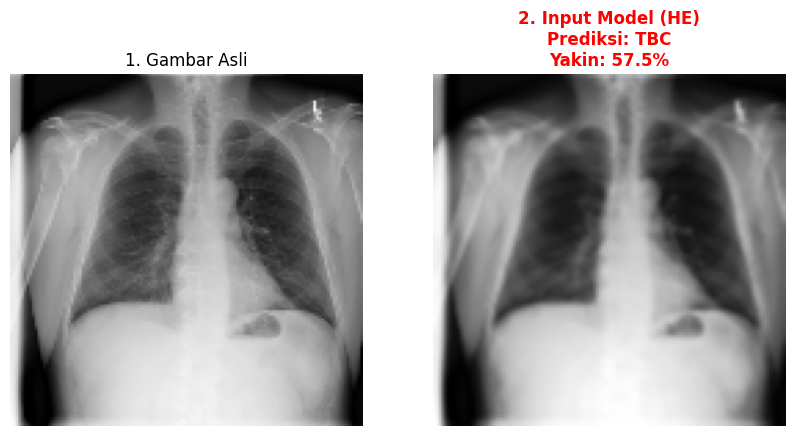

------------------------------
🩺 HASIL DIAGNOSA FINAL
------------------------------
Status     : TBC
Probabilitas: Normal=42.5%, TBC=57.5%
------------------------------


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from scipy.stats import skew

# --- FUNGSI TESTING KHUSUS (METODE STABIL) ---
def test_single_image_stable(path_img):
    # 1. BACA GAMBAR
    img = cv2.imread(path_img, 0)
    if img is None:
        print("Error: Gambar tidak terbaca.")
        return

    # 2. PREPROCESSING (SAMA PERSIS DENGAN TRAINING TERAKHIR)
    # Resize ke ukuran asli input (128)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Histogram Equalization (Kunci keberhasilan model ini)
    img_eq = cv2.equalizeHist(img_resized)

    # Gaussian Blur
    img_blur = cv2.GaussianBlur(img_eq, (3,3), 0)

    # 3. EKSTRAKSI FITUR (SIMPEL)
    features = []

    # A. Pixel Value (Thumbnail 32x32)
    thumb = cv2.resize(img_blur, (32, 32)).ravel()
    features.extend(thumb)

    # B. Sobel
    sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)

    features.append(np.mean(sobel_mag))
    features.append(np.std(sobel_mag))
    features.append(skew(sobel_mag.ravel()))

    # 4. PERSIAPAN DATA
    features = np.array(features).reshape(1, -1)
    features = np.nan_to_num(features)

    # A. Scaling (Pakai scaler dari training)
    features_scaled = scaler.transform(features)

    # 5. PREDIKSI (Pakai rf dari training)
    prediction = rf.predict(features_scaled)[0]
    probabilities = rf.predict_proba(features_scaled)[0]

    label_pred = categories[prediction]
    conf_score = np.max(probabilities) * 100

    # --- VISUALISASI ---
    plt.figure(figsize=(10, 5))

    # Gambar Asli
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("1. Gambar Asli")
    plt.axis('off')

    # Gambar yang dilihat Model (Equalized)
    plt.subplot(1, 2, 2)
    plt.imshow(img_blur, cmap='gray')

    # Judul Hasil
    color_res = 'green' if label_pred == "Normal" else 'red'
    plt.title(f"2. Input Model (HE)\nPrediksi: {label_pred}\nYakin: {conf_score:.1f}%",
              color=color_res, fontweight='bold')
    plt.axis('off')

    plt.show()

    print("-" * 30)
    print(f"🩺 HASIL DIAGNOSA FINAL")
    print("-" * 30)
    print(f"Status     : {label_pred}")
    print(f"Probabilitas: Normal={probabilities[0]*100:.1f}%, TBC={probabilities[1]*100:.1f}%")
    print("-" * 30)

# --- UPLOAD FILE ---
print("Silakan Upload Gambar X-Ray Baru:")
uploaded = files.upload()

for fn in uploaded.keys():
    test_single_image_stable(fn)